In [1]:
import pandas as pd
import glob,os
import numpy as np
import pandas as pd 
import numpy.matlib
import math
import optuna
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
#import tensorflow as tf
%matplotlib inline

In [2]:
def get_all_time_series():
    path = r'./COVID-19/csse_covid_19_data/csse_covid_19_time_series'
    all_files = glob.glob(os.path.join(path, "*.csv"))
    for i in [0,3,4]:
        file = all_files[i]
        df = pd.read_csv(file)
        #confirmed_all = dict()
        if i==0:
            df_confirmed = pd.DataFrame()
            for row in df.values:
                df_confirmed[row[1]] = row[4:]
        if i==3:
            df_recovered = pd.DataFrame()
            for row in df.values:
                df_recovered[row[1]] = row[4:]
        if i==4:
            df_deaths = pd.DataFrame()
            for row in df.values:
                df_deaths[row[1]] = row[4:]
    df_infected = df_confirmed - df_deaths - df_recovered
    return [df_infected,df_confirmed,df_recovered,df_deaths]

In [3]:
[df_infected,df_confirmed,df_recovered,df_deaths] = get_all_time_series()

In [4]:
for index in df_infected.keys():
    print(index)

Afghanistan
Albania
Algeria
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei
Bulgaria
Burkina Faso
Burma
Burundi
Cabo Verde
Cambodia
Cameroon
Canada
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo (Brazzaville)
Congo (Kinshasa)
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Cyprus
Czechia
Denmark
Diamond Princess
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Holy See
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Korea, South
Kosovo
Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Lesotho
Liberia
Libya
Liechtenstein
Lithuania
Luxembourg
MS Zaandam
Madagascar
Malawi
Malaysia
Maldives
Mali
Mal

In [5]:
len(df_infected.keys())

188

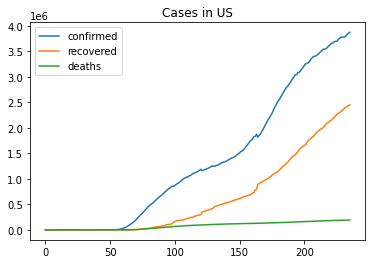

In [6]:
plt.plot(np.arange(len(df_confirmed['US'].values)),df_infected['US'].values,label='confirmed')
plt.plot(np.arange(len(df_recovered['US'].values)),df_recovered['US'].values,label='recovered')
plt.plot(np.arange(len(df_deaths['US'].values)),df_deaths['US'].values,label='deaths')
plt.legend()
plt.title('Cases in US')
plt.savefig("cases_in_US")

In [7]:
df_infected['US'].values

array([1, 1, 2, 2, 5, 5, 5, 5, 5, 7, 8, 8, 11, 11, 11, 11, 11, 11, 8, 8,
       9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 9,
       16, 22, 39, 58, 85, 153, 194, 313, 422, 486, 677, 1064, 1475, 2052,
       2744, 2904, 4240, 5821, 8090, 12288, 18225, 23869, 32401, 42910,
       52763, 64369, 81197, 98979, 118101, 135068, 152899, 176471, 199310,
       227685, 257524, 284208, 307696, 333435, 359459, 387211, 417888,
       445791, 471218, 496240, 509091, 529420, 551574, 578089, 604878,
       624893, 643743, 666952, 686893, 710629, 739313, 754574, 784504,
       804248, 820811, 838593, 858808, 852888, 875091, 891227, 910924,
       925038, 944294, 967067, 987889, 1009363, 1020067, 1035303, 1036603,
       1059612, 1065663, 1088513, 1107799, 1114055, 1128412, 1138096,
       1150779, 1168140, 1188172, 1159352, 1168962, 1183656, 1189678,
       1202154, 1212312, 1225466, 1242355, 1255827, 1246859, 1249965,
       1264155, 1267716, 1282300, 1299906, 1312836, 1324611, 1

In [8]:
us_population = 327200000

In [9]:
end_time = 80

num_times = len(df_infected['US'].values[0:end_time])
print(num_times)

80


In [10]:
def to_float(x):
    return float(x)

to_float_vec = np.vectorize(to_float)

In [53]:
Ic = df_infected['US'].values[0:end_time]
Dc = df_deaths['US'].values[0:end_time]

Ic = to_float_vec(Ic)
Dc = to_float_vec(Dc)

In [66]:
def objective(trial):
    beta = trial.suggest_uniform('beta', 0, 1)
    gamma = trial.suggest_uniform('gamma', 0, 1)
    mu = trial.suggest_uniform('mu', 0, 1)
    
    S = []
    I = []
    R = []
    D = []

    S.append(us_population-1.)
    I.append(1.)
    R.append(0.)
    D.append(0.)

    for i in range(num_times-1):
        Snew = S[i] - beta/us_population * S[i]*I[i]
        Inew = I[i] + beta/us_population * S[i]*I[i] - gamma*I[i] - mu*I[i]
        Rnew = R[i] + gamma* I[i]
        Dnew = D[i] + mu*I[i]
        S.append(Snew)
        I.append(Inew)
        R.append(Rnew)
        D.append(Dnew)
        
    I = np.array(I)
    D = np.array(D)
    
    epsilon = 0.000001
    #Ed1 = np.sum((np.log(Ic+epsilon)-np.log(I+epsilon))**2 + (np.log(Dc+epsilon)-np.log(D+epsilon))**2)
    #Ed2 = 0.01*(np.log(np.max(Ic)+epsilon)/np.max(Ic)) * np.sum((Ic-I)**2+ (Dc-D)**2)

    return np.sum((Ic-I)**2) + 100*np.sum((Dc-D)**2)
    #return Ed1 + Ed2

In [67]:
study = optuna.create_study()

In [68]:
study.optimize(objective, n_trials=3000)

study.best_params  # E.g. {'x': 2.002108042}

[I 2020-09-16 11:55:03,388] Trial 0 finished with value: 121862296511.57939 and parameters: {'beta': 0.3444183217845602, 'gamma': 0.6538610080767958, 'mu': 0.8158374342269199}. Best is trial 0 with value: 121862296511.57939.
[I 2020-09-16 11:55:03,390] Trial 1 finished with value: 121864171879.64372 and parameters: {'beta': 0.27682374055515846, 'gamma': 0.9305015464506551, 'mu': 0.3585214426686325}. Best is trial 0 with value: 121862296511.57939.
[I 2020-09-16 11:55:03,392] Trial 2 finished with value: 121858258317.12206 and parameters: {'beta': 0.7734545938468887, 'gamma': 0.47148656550977186, 'mu': 0.877503900827427}. Best is trial 2 with value: 121858258317.12206.
[I 2020-09-16 11:55:03,394] Trial 3 finished with value: 1.183926920722658e+16 and parameters: {'beta': 0.9850671598563918, 'gamma': 0.5597294809498027, 'mu': 0.0010536528435561854}. Best is trial 2 with value: 121858258317.12206.
[I 2020-09-16 11:55:03,396] Trial 4 finished with value: 121862932880.45586 and parameters: {

[I 2020-09-16 11:55:03,496] Trial 36 finished with value: 121850069921.60559 and parameters: {'beta': 0.9995045464606893, 'gamma': 0.4825471438441131, 'mu': 0.75731604101714}. Best is trial 23 with value: 117251886403.56482.
[I 2020-09-16 11:55:03,500] Trial 37 finished with value: 4.980267735119543e+16 and parameters: {'beta': 0.9391752881086484, 'gamma': 0.3941445908123482, 'mu': 0.2737508529404373}. Best is trial 23 with value: 117251886403.56482.
[I 2020-09-16 11:55:03,503] Trial 38 finished with value: 121724564845.9244 and parameters: {'beta': 0.7470494572735444, 'gamma': 0.16800160429946753, 'mu': 0.5893116567510541}. Best is trial 23 with value: 117251886403.56482.
[I 2020-09-16 11:55:03,507] Trial 39 finished with value: 121837927818.80803 and parameters: {'beta': 0.8575800200161681, 'gamma': 0.5367542975309829, 'mu': 0.39035190345929827}. Best is trial 23 with value: 117251886403.56482.
[I 2020-09-16 11:55:03,510] Trial 40 finished with value: 121855847744.98033 and parameter

[I 2020-09-16 11:55:03,639] Trial 72 finished with value: 120545770903.84616 and parameters: {'beta': 0.9468055740237171, 'gamma': 0.28715439221716366, 'mu': 0.6110948545497001}. Best is trial 42 with value: 114900467887.02354.
[I 2020-09-16 11:55:03,644] Trial 73 finished with value: 121694659572.27756 and parameters: {'beta': 0.8311509895636192, 'gamma': 0.1822611081380875, 'mu': 0.6561900009316824}. Best is trial 42 with value: 114900467887.02354.
[I 2020-09-16 11:55:03,648] Trial 74 finished with value: 121664100221.61978 and parameters: {'beta': 0.9846077816525036, 'gamma': 0.23530929379063195, 'mu': 0.7556979698808963}. Best is trial 42 with value: 114900467887.02354.
[I 2020-09-16 11:55:03,652] Trial 75 finished with value: 121839538886.86154 and parameters: {'beta': 0.8714037967808902, 'gamma': 0.4386977764649359, 'mu': 0.5344604706696503}. Best is trial 42 with value: 114900467887.02354.
[I 2020-09-16 11:55:03,655] Trial 76 finished with value: 121845501098.73634 and parameter

[I 2020-09-16 11:55:03,792] Trial 108 finished with value: 616884673088887.9 and parameters: {'beta': 0.98230867268609, 'gamma': 0.28107544052985534, 'mu': 0.48788364523662875}. Best is trial 88 with value: 114892757075.4677.
[I 2020-09-16 11:55:03,796] Trial 109 finished with value: 118849645541.6794 and parameters: {'beta': 0.9397407354840049, 'gamma': 0.32776260399306717, 'mu': 0.5418940830573935}. Best is trial 88 with value: 114892757075.4677.
[I 2020-09-16 11:55:03,800] Trial 110 finished with value: 119403165090.94589 and parameters: {'beta': 0.9367304019486508, 'gamma': 0.3267202385568834, 'mu': 0.5447943017546141}. Best is trial 88 with value: 114892757075.4677.
[I 2020-09-16 11:55:03,804] Trial 111 finished with value: 121546494164.5112 and parameters: {'beta': 0.9615686576578564, 'gamma': 0.4249371173281197, 'mu': 0.5189155330888208}. Best is trial 88 with value: 114892757075.4677.
[I 2020-09-16 11:55:03,808] Trial 112 finished with value: 121234466134.333 and parameters: {'

[I 2020-09-16 11:55:03,944] Trial 143 finished with value: 121248400236.61807 and parameters: {'beta': 0.9550432605212134, 'gamma': 0.2743932738339403, 'mu': 0.6515985893855669}. Best is trial 126 with value: 114829727330.95311.
[I 2020-09-16 11:55:03,954] Trial 144 finished with value: 2805827356098.205 and parameters: {'beta': 0.9793546907597755, 'gamma': 0.15285107725761404, 'mu': 0.6722667833709947}. Best is trial 126 with value: 114829727330.95311.
[I 2020-09-16 11:55:03,958] Trial 145 finished with value: 116167967194.68994 and parameters: {'beta': 0.957106301221619, 'gamma': 0.23913448655898306, 'mu': 0.6335411502729039}. Best is trial 126 with value: 114829727330.95311.
[I 2020-09-16 11:55:03,962] Trial 146 finished with value: 115013575849.63931 and parameters: {'beta': 0.9204539632215895, 'gamma': 0.19105432902081815, 'mu': 0.6309578035944423}. Best is trial 126 with value: 114829727330.95311.
[I 2020-09-16 11:55:03,967] Trial 147 finished with value: 78803242079236.75 and pa

[I 2020-09-16 11:55:04,102] Trial 178 finished with value: 173298668041.48346 and parameters: {'beta': 0.9991772463199099, 'gamma': 0.2870059983440949, 'mu': 0.5879759522898602}. Best is trial 174 with value: 114728939269.04866.
[I 2020-09-16 11:55:04,107] Trial 179 finished with value: 120797968131.14606 and parameters: {'beta': 0.9769456263313814, 'gamma': 0.36760309968253735, 'mu': 0.5640416851966956}. Best is trial 174 with value: 114728939269.04866.
[I 2020-09-16 11:55:04,111] Trial 180 finished with value: 120084533430.25311 and parameters: {'beta': 0.9287169814687624, 'gamma': 0.26538143812514076, 'mu': 0.6077330268774377}. Best is trial 174 with value: 114728939269.04866.
[I 2020-09-16 11:55:04,116] Trial 181 finished with value: 120689883987.16734 and parameters: {'beta': 0.9107764147343964, 'gamma': 0.2503395792936649, 'mu': 0.6146891069182846}. Best is trial 174 with value: 114728939269.04866.
[I 2020-09-16 11:55:04,120] Trial 182 finished with value: 115952325313.88702 and 

[I 2020-09-16 11:55:04,271] Trial 213 finished with value: 121537192915.82025 and parameters: {'beta': 0.9817829869223142, 'gamma': 0.429615968977595, 'mu': 0.5344352702382742}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,276] Trial 214 finished with value: 114762736662.86932 and parameters: {'beta': 0.9673302739791151, 'gamma': 0.3447530917676806, 'mu': 0.5263437392155658}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,280] Trial 215 finished with value: 121276542024.5498 and parameters: {'beta': 0.9618012620257829, 'gamma': 0.3337991528526991, 'mu': 0.5141752500291285}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,285] Trial 216 finished with value: 156679893673.09595 and parameters: {'beta': 0.9770369429818173, 'gamma': 0.4004709748727285, 'mu': 0.44906541962287194}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,290] Trial 217 finished with value: 120314980518.00107 and par

[I 2020-09-16 11:55:04,443] Trial 248 finished with value: 1872820740603.289 and parameters: {'beta': 0.9977983283222212, 'gamma': 0.34034225036134086, 'mu': 0.5013397828524735}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,448] Trial 249 finished with value: 121854324105.66896 and parameters: {'beta': 0.9993076186069905, 'gamma': 0.6741539117825242, 'mu': 0.5743047618879873}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,453] Trial 250 finished with value: 117830950678.38637 and parameters: {'beta': 0.9663835926634259, 'gamma': 0.2954472717692126, 'mu': 0.595361608550846}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,458] Trial 251 finished with value: 120986103931.1123 and parameters: {'beta': 0.9336732679798647, 'gamma': 0.3619769244336465, 'mu': 0.5295690966118753}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,463] Trial 252 finished with value: 134464354952.6759 and param

[I 2020-09-16 11:55:04,624] Trial 283 finished with value: 2.6093027603209907e+18 and parameters: {'beta': 0.9309893172595874, 'gamma': 0.10275339138491182, 'mu': 0.5218325936923542}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,630] Trial 284 finished with value: 121858599011.418 and parameters: {'beta': 0.5441700687387516, 'gamma': 0.3872839786577567, 'mu': 0.5001355952219412}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,636] Trial 285 finished with value: 117412852680.14313 and parameters: {'beta': 0.9607740102249632, 'gamma': 0.2829619214047604, 'mu': 0.5997679042613834}. Best is trial 189 with value: 114718038698.43352.
[I 2020-09-16 11:55:04,641] Trial 286 finished with value: 114602370850.95471 and parameters: {'beta': 0.9804165442892929, 'gamma': 0.34049159037574167, 'mu': 0.5399364003423289}. Best is trial 286 with value: 114602370850.95471.
[I 2020-09-16 11:55:04,647] Trial 287 finished with value: 120254400893.64262 an

[I 2020-09-16 11:55:04,815] Trial 318 finished with value: 121846679915.20763 and parameters: {'beta': 0.7230529225596499, 'gamma': 0.3676063739827161, 'mu': 0.48126867707335447}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:04,821] Trial 319 finished with value: 114841698069.91403 and parameters: {'beta': 0.931698553461851, 'gamma': 0.30277320508422434, 'mu': 0.5335001143563468}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:04,826] Trial 320 finished with value: 115861387211.99413 and parameters: {'beta': 0.9224338783968602, 'gamma': 0.3099767899624923, 'mu': 0.5043379686265884}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:04,831] Trial 321 finished with value: 121596157027.70932 and parameters: {'beta': 0.8951574586751612, 'gamma': 0.34731224852267284, 'mu': 0.5354957566060752}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:04,837] Trial 322 finished with value: 116821064034.3062 and p

[I 2020-09-16 11:55:05,011] Trial 353 finished with value: 121078854210.64659 and parameters: {'beta': 0.9090187852412194, 'gamma': 0.3408456622671279, 'mu': 0.5286103756329199}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,016] Trial 354 finished with value: 117604213916.78227 and parameters: {'beta': 0.9257159847829525, 'gamma': 0.28312166753250145, 'mu': 0.5646751903701149}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,022] Trial 355 finished with value: 121249208708.55649 and parameters: {'beta': 0.8906416588362555, 'gamma': 0.312835430309611, 'mu': 0.544701799095307}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,027] Trial 356 finished with value: 128340921729.3862 and parameters: {'beta': 0.8694864261634856, 'gamma': 0.23114663223223644, 'mu': 0.5210477563003906}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,033] Trial 357 finished with value: 115652323146.42108 and par

[I 2020-09-16 11:55:05,211] Trial 388 finished with value: 148988281137.831 and parameters: {'beta': 0.9328830435635, 'gamma': 0.33933550580542515, 'mu': 0.4682967316035727}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,217] Trial 389 finished with value: 118795830545.16335 and parameters: {'beta': 0.9994701200739255, 'gamma': 0.32308610031803836, 'mu': 0.6079932570147186}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,223] Trial 390 finished with value: 158327135081.0928 and parameters: {'beta': 0.9782128843080198, 'gamma': 0.35642068685628847, 'mu': 0.49613506579054334}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,229] Trial 391 finished with value: 1.0600393159338322e+19 and parameters: {'beta': 0.9529536717987176, 'gamma': 0.2977156329046832, 'mu': 0.2723037635315241}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,235] Trial 392 finished with value: 117656652118.40688 and 

[I 2020-09-16 11:55:05,419] Trial 423 finished with value: 121848120853.81732 and parameters: {'beta': 0.9725397012212585, 'gamma': 0.31349469251043804, 'mu': 0.9186152232475903}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,425] Trial 424 finished with value: 120568642899.47147 and parameters: {'beta': 0.9461600167404852, 'gamma': 0.3342098433555816, 'mu': 0.5620883533991384}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,431] Trial 425 finished with value: 19888202918725.53 and parameters: {'beta': 0.981671701941259, 'gamma': 0.26483952167738867, 'mu': 0.5392464021145327}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,437] Trial 426 finished with value: 120670649640.10974 and parameters: {'beta': 0.9172763085841383, 'gamma': 0.2902926662930414, 'mu': 0.5796410562819089}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,444] Trial 427 finished with value: 190784997662.07703 and pa

[I 2020-09-16 11:55:05,641] Trial 458 finished with value: 4977196721740.143 and parameters: {'beta': 0.9654903914077761, 'gamma': 0.34242971969687575, 'mu': 0.45554969801309775}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,647] Trial 459 finished with value: 138301833903613.28 and parameters: {'beta': 0.8729431698103017, 'gamma': 0.15660183728781155, 'mu': 0.5190600240267027}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,654] Trial 460 finished with value: 121329343885.67184 and parameters: {'beta': 0.9327763402881739, 'gamma': 0.37914560677025455, 'mu': 0.5229803233005829}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,660] Trial 461 finished with value: 940513796344601.1 and parameters: {'beta': 0.9672708054914063, 'gamma': 0.269275884723346, 'mu': 0.4801165714779223}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,666] Trial 462 finished with value: 35807820051746.125 and p

[I 2020-09-16 11:55:05,866] Trial 493 finished with value: 116814486090.0576 and parameters: {'beta': 0.9560922397109738, 'gamma': 0.36802165295365064, 'mu': 0.5036447738916827}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,873] Trial 494 finished with value: 1301528297596.1416 and parameters: {'beta': 0.9809261228992632, 'gamma': 0.3310861428973958, 'mu': 0.4971516783863919}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,879] Trial 495 finished with value: 119628962640.04074 and parameters: {'beta': 0.936489195476775, 'gamma': 0.3895998722404638, 'mu': 0.48157372912538754}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,886] Trial 496 finished with value: 114956682981.22778 and parameters: {'beta': 0.9192809803011879, 'gamma': 0.29980132784506636, 'mu': 0.5248457256123817}. Best is trial 290 with value: 114557587168.48294.
[I 2020-09-16 11:55:05,892] Trial 497 finished with value: 119420924724.12639 and p

[I 2020-09-16 11:55:06,112] Trial 528 finished with value: 116011137570.25327 and parameters: {'beta': 0.9273772927613223, 'gamma': 0.2757687289579411, 'mu': 0.5645145978772463}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,119] Trial 529 finished with value: 118681284733.24312 and parameters: {'beta': 0.8235980259430704, 'gamma': 0.21118515709777952, 'mu': 0.5409991807365603}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,126] Trial 530 finished with value: 114774911747.0333 and parameters: {'beta': 0.8844731374360345, 'gamma': 0.26640583665715933, 'mu': 0.5218990387634541}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,132] Trial 531 finished with value: 116753026027.33333 and parameters: {'beta': 0.8619967000328136, 'gamma': 0.260818222160168, 'mu': 0.5168322914359472}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,139] Trial 532 finished with value: 138672314794.56424 and pa

[I 2020-09-16 11:55:06,356] Trial 563 finished with value: 116192197697.48138 and parameters: {'beta': 0.9042571523211927, 'gamma': 0.27368881757908686, 'mu': 0.5439297168810653}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,363] Trial 564 finished with value: 121105949388.16508 and parameters: {'beta': 0.9477215234337725, 'gamma': 0.3463408483287449, 'mu': 0.5640523802186215}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,370] Trial 565 finished with value: 760953481018.1399 and parameters: {'beta': 0.965325227912828, 'gamma': 0.3013869703307516, 'mu': 0.5175086379175156}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,377] Trial 566 finished with value: 119303597564.82944 and parameters: {'beta': 0.9215916973555481, 'gamma': 0.31785644480761355, 'mu': 0.5373375284255278}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,384] Trial 567 finished with value: 121860063633.90494 and pa

[I 2020-09-16 11:55:06,608] Trial 598 finished with value: 114755004172.0078 and parameters: {'beta': 0.965826342605774, 'gamma': 0.2794203921954439, 'mu': 0.5890501911737669}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,615] Trial 599 finished with value: 344630941059.04425 and parameters: {'beta': 0.9757294422661505, 'gamma': 0.3492824485754124, 'mu': 0.4877032078831504}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,622] Trial 600 finished with value: 115037586191.14073 and parameters: {'beta': 0.9847671600689596, 'gamma': 0.29641972118081833, 'mu': 0.5954942839625242}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,629] Trial 601 finished with value: 119999924479.69212 and parameters: {'beta': 0.9642729957719652, 'gamma': 0.31926213251879015, 'mu': 0.5876743643899354}. Best is trial 499 with value: 114533063486.10506.
[I 2020-09-16 11:55:06,637] Trial 602 finished with value: 117743212563.26753 and pa

[I 2020-09-16 11:55:06,878] Trial 633 finished with value: 114660099526.25877 and parameters: {'beta': 0.8396324855182328, 'gamma': 0.3304530272085642, 'mu': 0.4101011754353786}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:06,885] Trial 634 finished with value: 121237049961.21455 and parameters: {'beta': 0.8322036723408275, 'gamma': 0.3287400475060256, 'mu': 0.46646639267869994}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:06,893] Trial 635 finished with value: 141875003164.87943 and parameters: {'beta': 0.8565509000710411, 'gamma': 0.2949837647304203, 'mu': 0.43630210058905117}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:06,901] Trial 636 finished with value: 31224651702918.27 and parameters: {'beta': 0.8187399923635996, 'gamma': 0.26488747938423696, 'mu': 0.3641318511341191}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:06,909] Trial 637 finished with value: 847447139731.6687 and param

[I 2020-09-16 11:55:07,154] Trial 668 finished with value: 118220281986.60985 and parameters: {'beta': 0.8629631102687846, 'gamma': 0.2966842359566109, 'mu': 0.4898145966274715}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,162] Trial 669 finished with value: 1319487188375.6946 and parameters: {'beta': 0.87882080539081, 'gamma': 0.2554814858054539, 'mu': 0.46936964538020604}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,170] Trial 670 finished with value: 12395066158690.158 and parameters: {'beta': 0.9028855776699636, 'gamma': 0.31808857663405765, 'mu': 0.40619982095695145}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,177] Trial 671 finished with value: 120465479932.00858 and parameters: {'beta': 0.8319400822037062, 'gamma': 0.28512018426305663, 'mu': 0.4925598043871581}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,185] Trial 672 finished with value: 992516310139.9513 and param

[I 2020-09-16 11:55:07,435] Trial 703 finished with value: 114766226686.94116 and parameters: {'beta': 0.9501676919141729, 'gamma': 0.2614298403068993, 'mu': 0.5908643610237014}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,443] Trial 704 finished with value: 115138687571.91998 and parameters: {'beta': 0.9556491562183346, 'gamma': 0.25456731481905875, 'mu': 0.6093100319407407}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,451] Trial 705 finished with value: 230699865825.92874 and parameters: {'beta': 0.9742238729189214, 'gamma': 0.21280857389492566, 'mu': 0.6335613609562585}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,458] Trial 706 finished with value: 116438385054.59425 and parameters: {'beta': 0.9199202319839993, 'gamma': 0.19146651149669058, 'mu': 0.6246816851632714}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,466] Trial 707 finished with value: 262406660915.43225 and par

[I 2020-09-16 11:55:07,723] Trial 738 finished with value: 121503105971.97682 and parameters: {'beta': 0.9549222904258081, 'gamma': 0.33974273488901574, 'mu': 0.5976572616959811}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,731] Trial 739 finished with value: 101168590144384.12 and parameters: {'beta': 0.9337896138066009, 'gamma': 0.2433251558843672, 'mu': 0.4953174502208035}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,739] Trial 740 finished with value: 121848903733.95853 and parameters: {'beta': 0.9996600991593985, 'gamma': 0.305291014011732, 'mu': 0.9857303132835554}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,747] Trial 741 finished with value: 120873790542.578 and parameters: {'beta': 0.8651274043908764, 'gamma': 0.26595156640169043, 'mu': 0.5552551080147976}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:07,756] Trial 742 finished with value: 170064143230.73422 and paramet

[I 2020-09-16 11:55:08,014] Trial 773 finished with value: 121863006204.20995 and parameters: {'beta': 0.0008142179226371948, 'gamma': 0.34909271463572694, 'mu': 0.4902110256408843}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:08,023] Trial 774 finished with value: 272564418962.41486 and parameters: {'beta': 0.9559018020624342, 'gamma': 0.2614386230825645, 'mu': 0.5616786161696188}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:08,032] Trial 775 finished with value: 183876515994.3429 and parameters: {'beta': 0.9778618460743221, 'gamma': 0.3061341142494649, 'mu': 0.5447205874282529}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:08,041] Trial 776 finished with value: 121754793922.8368 and parameters: {'beta': 0.8944430294860584, 'gamma': 0.39140079056350907, 'mu': 0.5173029415672225}. Best is trial 631 with value: 114444321042.6839.
[I 2020-09-16 11:55:08,051] Trial 777 finished with value: 218511505649045.03 and par

[I 2020-09-16 11:55:08,321] Trial 808 finished with value: 120016768905.26923 and parameters: {'beta': 0.843466842108265, 'gamma': 0.3436889047929253, 'mu': 0.4369385955909596}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,330] Trial 809 finished with value: 860678071976.3477 and parameters: {'beta': 0.9022778657626594, 'gamma': 0.3162402855962874, 'mu': 0.43484650822489274}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,339] Trial 810 finished with value: 119019441617.67877 and parameters: {'beta': 0.8521834323251396, 'gamma': 0.36939009576785753, 'mu': 0.4089788931214105}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,347] Trial 811 finished with value: 4960420766623835.0 and parameters: {'beta': 0.858138441264733, 'gamma': 0.20133049537402792, 'mu': 0.41948464717607137}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,357] Trial 812 finished with value: 120501528389.6141 and parame

[I 2020-09-16 11:55:08,633] Trial 843 finished with value: 13243242249764.717 and parameters: {'beta': 0.92903684125425, 'gamma': 0.2508317534963517, 'mu': 0.5032003768531688}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,642] Trial 844 finished with value: 31635741183641.9 and parameters: {'beta': 0.8542085925108864, 'gamma': 0.22566134626618892, 'mu': 0.44255233335311245}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,651] Trial 845 finished with value: 119883712304.94492 and parameters: {'beta': 0.9648331496863956, 'gamma': 0.3301067284550871, 'mu': 0.522345200300398}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,660] Trial 846 finished with value: 120845580860.06833 and parameters: {'beta': 0.9051002582268786, 'gamma': 0.2767793947000656, 'mu': 0.5848404050982862}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,669] Trial 847 finished with value: 119715662432.49838 and parameter

[I 2020-09-16 11:55:08,951] Trial 878 finished with value: 120754009847.26997 and parameters: {'beta': 0.8124782539183139, 'gamma': 0.3418707018670127, 'mu': 0.4182986487019937}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,960] Trial 879 finished with value: 116303914565.76292 and parameters: {'beta': 0.8150447375321194, 'gamma': 0.22115714146591742, 'mu': 0.48384049590931333}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,970] Trial 880 finished with value: 196591775495.13635 and parameters: {'beta': 0.8412817331039575, 'gamma': 0.2630800922494634, 'mu': 0.4457736255523897}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,979] Trial 881 finished with value: 207828686892.63184 and parameters: {'beta': 0.8513218827468171, 'gamma': 0.24279374168754825, 'mu': 0.47651371839320594}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:08,988] Trial 882 finished with value: 120991821000.48569 and pa

[I 2020-09-16 11:55:09,279] Trial 913 finished with value: 115009204374.30945 and parameters: {'beta': 0.8964317191428746, 'gamma': 0.3232644248385973, 'mu': 0.47790578223691005}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:09,288] Trial 914 finished with value: 74380075088281.73 and parameters: {'beta': 0.8885261294861951, 'gamma': 0.276476246695198, 'mu': 0.41649605313258675}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:09,298] Trial 915 finished with value: 121407097530.07466 and parameters: {'beta': 0.8261950158398395, 'gamma': 0.34400268868523587, 'mu': 0.4520285918394874}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:09,307] Trial 916 finished with value: 118863505715.59357 and parameters: {'beta': 0.8495133359867043, 'gamma': 0.3018052348613316, 'mu': 0.47535178982573284}. Best is trial 807 with value: 114194684835.2008.
[I 2020-09-16 11:55:09,317] Trial 917 finished with value: 30428481749736.555 and para

[I 2020-09-16 11:55:09,606] Trial 948 finished with value: 154373050300.8309 and parameters: {'beta': 0.7695066416067303, 'gamma': 0.402049432209469, 'mu': 0.22544619812872319}. Best is trial 940 with value: 113006476972.24309.
[I 2020-09-16 11:55:09,616] Trial 949 finished with value: 113056720426.08893 and parameters: {'beta': 0.769989795197897, 'gamma': 0.38829011465867624, 'mu': 0.269960509493797}. Best is trial 940 with value: 113006476972.24309.
[I 2020-09-16 11:55:09,626] Trial 950 finished with value: 121741803668.31119 and parameters: {'beta': 0.7417397853426018, 'gamma': 0.4268483426534948, 'mu': 0.30954252779470237}. Best is trial 940 with value: 113006476972.24309.
[I 2020-09-16 11:55:09,636] Trial 951 finished with value: 121376812121.63794 and parameters: {'beta': 0.7330340429736599, 'gamma': 0.4221794294836185, 'mu': 0.26794044101934483}. Best is trial 940 with value: 113006476972.24309.
[I 2020-09-16 11:55:09,646] Trial 952 finished with value: 115025832622.48187 and pa

[I 2020-09-16 11:55:09,945] Trial 983 finished with value: 119337824646.69315 and parameters: {'beta': 0.7246586981374873, 'gamma': 0.379347324088383, 'mu': 0.2667261881074743}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:09,955] Trial 984 finished with value: 120347106064.7351 and parameters: {'beta': 0.7764408728558377, 'gamma': 0.3882990281483989, 'mu': 0.32406348687693787}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:09,964] Trial 985 finished with value: 119695524216.1052 and parameters: {'beta': 0.7473845884468943, 'gamma': 0.37113506023975396, 'mu': 0.3031980001132608}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:09,974] Trial 986 finished with value: 534382557228.4458 and parameters: {'beta': 0.7868134573730013, 'gamma': 0.38153485670374415, 'mu': 0.24771919885063187}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:09,983] Trial 987 finished with value: 121462929560.31137 and pa

[I 2020-09-16 11:55:10,298] Trial 1018 finished with value: 116973631776.04936 and parameters: {'beta': 0.7820399869049139, 'gamma': 0.3460230717573432, 'mu': 0.31401244674785056}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:10,308] Trial 1019 finished with value: 113666636426.99539 and parameters: {'beta': 0.8222097994972685, 'gamma': 0.353701006172965, 'mu': 0.3595888036810018}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:10,318] Trial 1020 finished with value: 120760561348.46397 and parameters: {'beta': 0.8120336968904026, 'gamma': 0.4012267328999616, 'mu': 0.35543157195241537}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:10,328] Trial 1021 finished with value: 121286385082.16167 and parameters: {'beta': 0.7915154687431267, 'gamma': 0.38032484133108735, 'mu': 0.3711898013007691}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:10,338] Trial 1022 finished with value: 24802917613052.207

[I 2020-09-16 11:55:10,647] Trial 1053 finished with value: 121706151460.91362 and parameters: {'beta': 0.7208586203573394, 'gamma': 0.3919909359511179, 'mu': 0.3170857171091255}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:10,657] Trial 1054 finished with value: 114691107409.792 and parameters: {'beta': 0.7901959368380274, 'gamma': 0.4162733702019423, 'mu': 0.27028500775820963}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:10,667] Trial 1055 finished with value: 121140082089.29752 and parameters: {'beta': 0.808794684363687, 'gamma': 0.37822364063607933, 'mu': 0.38625697376174634}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:10,677] Trial 1056 finished with value: 1104546524382.9734 and parameters: {'beta': 0.7948822800723968, 'gamma': 0.39193263159547864, 'mu': 0.23706456686281274}. Best is trial 974 with value: 112929069310.14252.
[I 2020-09-16 11:55:10,688] Trial 1057 finished with value: 115790480420.34067

[I 2020-09-16 11:55:11,017] Trial 1088 finished with value: 121313446619.67511 and parameters: {'beta': 0.731207900714644, 'gamma': 0.4652646449495738, 'mu': 0.21610341820118373}. Best is trial 1087 with value: 111688511860.07108.
[I 2020-09-16 11:55:11,027] Trial 1089 finished with value: 115401886059.51572 and parameters: {'beta': 0.7637865252643022, 'gamma': 0.48567968195138445, 'mu': 0.17173313619777866}. Best is trial 1087 with value: 111688511860.07108.
[I 2020-09-16 11:55:11,038] Trial 1090 finished with value: 121670863124.86281 and parameters: {'beta': 0.7218877200765751, 'gamma': 0.4974546134168418, 'mu': 0.1960960573998712}. Best is trial 1087 with value: 111688511860.07108.
[I 2020-09-16 11:55:11,048] Trial 1091 finished with value: 156655832272.81476 and parameters: {'beta': 0.7519936628264734, 'gamma': 0.4408938981395493, 'mu': 0.16122423239743897}. Best is trial 1087 with value: 111688511860.07108.
[I 2020-09-16 11:55:11,059] Trial 1092 finished with value: 120765993224.

[I 2020-09-16 11:55:11,386] Trial 1123 finished with value: 121829908579.5983 and parameters: {'beta': 0.7446377377465279, 'gamma': 0.4832936459505073, 'mu': 0.3003122603016405}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:11,397] Trial 1124 finished with value: 121661670010.08139 and parameters: {'beta': 0.6636035856205479, 'gamma': 0.4060596441613524, 'mu': 0.23183403774674097}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:11,407] Trial 1125 finished with value: 118420644562.96524 and parameters: {'beta': 0.7695940726852017, 'gamma': 0.40246850424704544, 'mu': 0.2826424744597398}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:11,418] Trial 1126 finished with value: 120481269997.21828 and parameters: {'beta': 0.8025397065764008, 'gamma': 0.43849378502942293, 'mu': 0.30058801881829567}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:11,429] Trial 1127 finished with value: 1.55591739355

[I 2020-09-16 11:55:11,763] Trial 1158 finished with value: 125524991524.22276 and parameters: {'beta': 0.7544327082170847, 'gamma': 0.4372230557856934, 'mu': 0.17588725502630817}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:11,775] Trial 1159 finished with value: 570200312650.4319 and parameters: {'beta': 0.7099846366774691, 'gamma': 0.3880695715371241, 'mu': 0.15391912737317426}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:11,786] Trial 1160 finished with value: 120890348681.23402 and parameters: {'beta': 0.7345594201602977, 'gamma': 0.42345029544513585, 'mu': 0.2519224378727865}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:11,796] Trial 1161 finished with value: 119564560622.02534 and parameters: {'beta': 0.7579965638612102, 'gamma': 0.4109763034640838, 'mu': 0.2707302660607006}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:11,807] Trial 1162 finished with value: 117282729403.3

[I 2020-09-16 11:55:12,150] Trial 1193 finished with value: 116875089535.34712 and parameters: {'beta': 0.7357479828954363, 'gamma': 0.4187139561730982, 'mu': 0.220163358235994}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:12,161] Trial 1194 finished with value: 121087218540.88832 and parameters: {'beta': 0.6939265787423162, 'gamma': 0.4042246143778585, 'mu': 0.23396968636139062}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:12,172] Trial 1195 finished with value: 119703028257.00166 and parameters: {'beta': 0.7258513371338999, 'gamma': 0.43842561082013287, 'mu': 0.20806083583393117}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:12,183] Trial 1196 finished with value: 121833064765.13815 and parameters: {'beta': 0.6037206776985815, 'gamma': 0.39286321899034315, 'mu': 0.24453489539363313}. Best is trial 1094 with value: 110336310146.00677.
[I 2020-09-16 11:55:12,194] Trial 1197 finished with value: 334820522168

[I 2020-09-16 11:55:12,542] Trial 1228 finished with value: 121844332437.12787 and parameters: {'beta': 0.6210037800907137, 'gamma': 0.5766033602532805, 'mu': 0.030074419497853028}. Best is trial 1226 with value: 98838477525.64688.
[I 2020-09-16 11:55:12,553] Trial 1229 finished with value: 104831779167.45203 and parameters: {'beta': 0.6684584189516852, 'gamma': 0.5204178062895667, 'mu': 0.0010765154278272668}. Best is trial 1226 with value: 98838477525.64688.
[I 2020-09-16 11:55:12,565] Trial 1230 finished with value: 118333538643.18703 and parameters: {'beta': 0.6562463124446174, 'gamma': 0.533977167991746, 'mu': 0.0036694604079002754}. Best is trial 1226 with value: 98838477525.64688.
[I 2020-09-16 11:55:12,578] Trial 1231 finished with value: 121480553364.37337 and parameters: {'beta': 0.6534425372625083, 'gamma': 0.5676297183760859, 'mu': 0.005525253090903161}. Best is trial 1226 with value: 98838477525.64688.
[I 2020-09-16 11:55:12,589] Trial 1232 finished with value: 11825842547

[I 2020-09-16 11:55:12,949] Trial 1263 finished with value: 120524553079.07425 and parameters: {'beta': 0.6106809173570446, 'gamma': 0.506924546077952, 'mu': 0.0003566412325148638}. Best is trial 1240 with value: 26743178901.68011.
[I 2020-09-16 11:55:12,961] Trial 1264 finished with value: 121724087972.11855 and parameters: {'beta': 0.6479414528273144, 'gamma': 0.57017860494237, 'mu': 0.021904014982076784}. Best is trial 1240 with value: 26743178901.68011.
[I 2020-09-16 11:55:12,972] Trial 1265 finished with value: 114939451487.67484 and parameters: {'beta': 0.6852063289273823, 'gamma': 0.5194226432117396, 'mu': 0.04462163276078475}. Best is trial 1240 with value: 26743178901.68011.
[I 2020-09-16 11:55:12,984] Trial 1266 finished with value: 121585629758.18767 and parameters: {'beta': 0.6637577207741371, 'gamma': 0.5377153388884093, 'mu': 0.07121404343498873}. Best is trial 1240 with value: 26743178901.68011.
[I 2020-09-16 11:55:12,996] Trial 1267 finished with value: 41204010603.0626

[I 2020-09-16 11:55:13,368] Trial 1298 finished with value: 121802296819.8221 and parameters: {'beta': 0.6666177745666413, 'gamma': 0.5960180847531996, 'mu': 0.03568018352848815}. Best is trial 1240 with value: 26743178901.68011.
[I 2020-09-16 11:55:13,380] Trial 1299 finished with value: 13184626577.324226 and parameters: {'beta': 0.6761044920646962, 'gamma': 0.48795527916791565, 'mu': 7.519845831617479e-05}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:13,394] Trial 1300 finished with value: 111210553290.7365 and parameters: {'beta': 0.6477028362164604, 'gamma': 0.49471881121559436, 'mu': 0.019009396787464303}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:13,407] Trial 1301 finished with value: 121721521037.7205 and parameters: {'beta': 0.6233368436737899, 'gamma': 0.523870240962726, 'mu': 0.05381668460243881}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:13,419] Trial 1302 finished with value: 116080193397

[I 2020-09-16 11:55:13,804] Trial 1333 finished with value: 100193392364.82487 and parameters: {'beta': 0.6973662464172616, 'gamma': 0.4809400584001497, 'mu': 0.07066586275414734}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:13,816] Trial 1334 finished with value: 105623534497.72186 and parameters: {'beta': 0.6985469580808066, 'gamma': 0.48137877648216, 'mu': 0.08082269869319507}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:13,828] Trial 1335 finished with value: 108941999592.41885 and parameters: {'beta': 0.6905094212694793, 'gamma': 0.4837617806242126, 'mu': 0.07629684094606332}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:13,841] Trial 1336 finished with value: 97772488824.48857 and parameters: {'beta': 0.7042587972483455, 'gamma': 0.4813870854438787, 'mu': 0.06437907116850348}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:13,854] Trial 1337 finished with value: 112963567406.01

[I 2020-09-16 11:55:14,245] Trial 1368 finished with value: 109053197804.22824 and parameters: {'beta': 0.7167492216413711, 'gamma': 0.5373460716689208, 'mu': 0.04630032262257759}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:14,258] Trial 1369 finished with value: 85595315176.15762 and parameters: {'beta': 0.713421562273012, 'gamma': 0.500050703381084, 'mu': 0.044526947447800565}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:14,271] Trial 1370 finished with value: 93283211380.19168 and parameters: {'beta': 0.7176010803903013, 'gamma': 0.5007902267943021, 'mu': 0.04305741200201866}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:14,284] Trial 1371 finished with value: 115514063540.48639 and parameters: {'beta': 0.7112472580231513, 'gamma': 0.4982953325525111, 'mu': 0.10087166741105119}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:14,297] Trial 1372 finished with value: 107152849732.90

[I 2020-09-16 11:55:14,689] Trial 1403 finished with value: 121326895828.92775 and parameters: {'beta': 0.7255362366817121, 'gamma': 0.591590568229216, 'mu': 0.06500248513530696}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:14,701] Trial 1404 finished with value: 105162935611.45505 and parameters: {'beta': 0.7281028084263995, 'gamma': 0.5605351520131885, 'mu': 0.026497526750727626}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:14,715] Trial 1405 finished with value: 118374470525.11377 and parameters: {'beta': 0.7285160845697985, 'gamma': 0.5455482795941429, 'mu': 0.0806401722739702}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:14,727] Trial 1406 finished with value: 118783995998.96361 and parameters: {'beta': 0.7060258721681362, 'gamma': 0.5461802986229278, 'mu': 0.05609627087209103}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:14,740] Trial 1407 finished with value: 121863884919.

[I 2020-09-16 11:55:15,148] Trial 1438 finished with value: 118954226303.81833 and parameters: {'beta': 0.7368878544915671, 'gamma': 0.5966298825815044, 'mu': 0.033025763237798676}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:15,161] Trial 1439 finished with value: 114991050802.72273 and parameters: {'beta': 0.7239675019502176, 'gamma': 0.5789653023233181, 'mu': 0.018992860664430088}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:15,174] Trial 1440 finished with value: 73284478744.14268 and parameters: {'beta': 0.738399931910767, 'gamma': 0.5548844240506038, 'mu': 0.019680759195130407}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:15,186] Trial 1441 finished with value: 84558823681.83337 and parameters: {'beta': 0.7416274863107306, 'gamma': 0.5622717135114864, 'mu': 0.02142479429555495}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:15,199] Trial 1442 finished with value: 109230137306

[I 2020-09-16 11:55:15,599] Trial 1473 finished with value: 35213084769.40959 and parameters: {'beta': 0.764542362850674, 'gamma': 0.5831612201747635, 'mu': 0.0019304451125431922}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:15,613] Trial 1474 finished with value: 108937665915.11954 and parameters: {'beta': 0.7610396235549468, 'gamma': 0.6182498874851181, 'mu': 0.0006042922989435671}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:15,626] Trial 1475 finished with value: 32325612912.415646 and parameters: {'beta': 0.7689898473735491, 'gamma': 0.5863442629909519, 'mu': 0.0025596775575442467}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:15,639] Trial 1476 finished with value: 82252998916.62593 and parameters: {'beta': 0.7679987744850836, 'gamma': 0.6048529951202122, 'mu': 0.00012878292000336464}. Best is trial 1299 with value: 13184626577.324226.
[I 2020-09-16 11:55:15,651] Trial 1477 finished with value: 118972

[I 2020-09-16 11:55:16,058] Trial 1508 finished with value: 55949836493.54817 and parameters: {'beta': 0.7940391436796653, 'gamma': 0.6202678548749598, 'mu': 0.0002106291125855604}. Best is trial 1486 with value: 11477070502.368938.
[I 2020-09-16 11:55:16,071] Trial 1509 finished with value: 90191780486.51561 and parameters: {'beta': 0.7920648408434643, 'gamma': 0.6331175464421528, 'mu': 0.0002940393720078055}. Best is trial 1486 with value: 11477070502.368938.
[I 2020-09-16 11:55:16,084] Trial 1510 finished with value: 115106595313.12422 and parameters: {'beta': 0.7955593658298777, 'gamma': 0.6497147820358691, 'mu': 0.020484131623296205}. Best is trial 1486 with value: 11477070502.368938.
[I 2020-09-16 11:55:16,097] Trial 1511 finished with value: 54834364174.85215 and parameters: {'beta': 0.794666730191025, 'gamma': 0.619674843649797, 'mu': 0.001553654113513069}. Best is trial 1486 with value: 11477070502.368938.
[I 2020-09-16 11:55:16,111] Trial 1512 finished with value: 39015663385

[I 2020-09-16 11:55:16,526] Trial 1543 finished with value: 119276962781.23468 and parameters: {'beta': 0.8124058083126736, 'gamma': 0.6972192150389804, 'mu': 0.0009207794046372023}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:16,539] Trial 1544 finished with value: 81944434684.84612 and parameters: {'beta': 0.8108418362665423, 'gamma': 0.6190187945047695, 'mu': 0.03222049825228947}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:16,553] Trial 1545 finished with value: 20759557957.13338 and parameters: {'beta': 0.789736650648008, 'gamma': 0.5916543912522298, 'mu': 0.0005499496647060667}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:16,567] Trial 1546 finished with value: 47903204328.67453 and parameters: {'beta': 0.7714224085650806, 'gamma': 0.5773391799791703, 'mu': 0.019243173658235614}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:16,580] Trial 1547 finished with value: 91151786176.612

[I 2020-09-16 11:55:17,008] Trial 1578 finished with value: 49883344755.44851 and parameters: {'beta': 0.8327505373769981, 'gamma': 0.6567445332435311, 'mu': 0.0005707885937977549}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:17,023] Trial 1579 finished with value: 37503540022.85788 and parameters: {'beta': 0.8419962734151055, 'gamma': 0.6418162104717114, 'mu': 0.01942554885941518}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:17,036] Trial 1580 finished with value: 93717835791.66435 and parameters: {'beta': 0.8370689272864216, 'gamma': 0.665932632699911, 'mu': 0.018699818773627624}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:17,052] Trial 1581 finished with value: 83388190556.57054 and parameters: {'beta': 0.8435594241006054, 'gamma': 0.6463552322798193, 'mu': 0.037774744045849455}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:17,066] Trial 1582 finished with value: 112778596660.2513

[I 2020-09-16 11:55:17,500] Trial 1613 finished with value: 41984366375.7386 and parameters: {'beta': 0.8578639486861813, 'gamma': 0.6501431727405034, 'mu': 0.01877206423548749}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:17,514] Trial 1614 finished with value: 121582229562.51567 and parameters: {'beta': 0.835137918338542, 'gamma': 0.7567311857409955, 'mu': 0.0011293247717548442}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:17,528] Trial 1615 finished with value: 52240093283.86601 and parameters: {'beta': 0.8592618737089135, 'gamma': 0.6679465809791992, 'mu': 0.0185086850780941}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:17,542] Trial 1616 finished with value: 43153904068.188324 and parameters: {'beta': 0.8291419593983671, 'gamma': 0.6508476794392537, 'mu': 0.0008242862261463749}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:17,556] Trial 1617 finished with value: 121649767468.6585

[I 2020-09-16 11:55:17,995] Trial 1648 finished with value: 32985400796.73263 and parameters: {'beta': 0.8089248352450381, 'gamma': 0.6276109800059341, 'mu': 0.0005892735835371493}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:18,009] Trial 1649 finished with value: 21251888423.05984 and parameters: {'beta': 0.8068752998089963, 'gamma': 0.6218995527025708, 'mu': 0.00025859073045627246}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:18,023] Trial 1650 finished with value: 16316220237.491777 and parameters: {'beta': 0.8087303283608753, 'gamma': 0.6219406226785101, 'mu': 0.00012316176790016446}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:18,038] Trial 1651 finished with value: 23906821902.216633 and parameters: {'beta': 0.8037995253292582, 'gamma': 0.6197450879497668, 'mu': 0.00021572925563174386}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:18,052] Trial 1652 finished with value: 8974007

[I 2020-09-16 11:55:18,494] Trial 1683 finished with value: 121858615649.02121 and parameters: {'beta': 0.8184077164517473, 'gamma': 0.6014455112888445, 'mu': 0.6950443136399406}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:18,509] Trial 1684 finished with value: 563796808406.9779 and parameters: {'beta': 0.8508932123700598, 'gamma': 0.636649503336312, 'mu': 0.0008309330866418134}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:18,523] Trial 1685 finished with value: 86208723124.29468 and parameters: {'beta': 0.7957434049937816, 'gamma': 0.6192764309919127, 'mu': 0.019312187860691853}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:18,537] Trial 1686 finished with value: 120424445019.61298 and parameters: {'beta': 0.8155762734797146, 'gamma': 0.6673474895213347, 'mu': 0.05946179584463386}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:18,551] Trial 1687 finished with value: 121865944899.7993

[I 2020-09-16 11:55:19,006] Trial 1718 finished with value: 9436229340.389725 and parameters: {'beta': 0.8357443467644067, 'gamma': 0.6422280512762922, 'mu': 2.8313242288098518e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:19,021] Trial 1719 finished with value: 120002902724.33673 and parameters: {'beta': 0.8406214079966182, 'gamma': 0.6858438086819926, 'mu': 0.06153637000330203}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:19,035] Trial 1720 finished with value: 1111491120166.659 and parameters: {'beta': 0.8671383334184344, 'gamma': 0.6489346415904256, 'mu': 0.0002313814877963096}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:19,051] Trial 1721 finished with value: 74492679787.1842 and parameters: {'beta': 0.8395818082302756, 'gamma': 0.6366839029699027, 'mu': 0.03592549756406715}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:19,066] Trial 1722 finished with value: 17257968520.243

[I 2020-09-16 11:55:19,518] Trial 1753 finished with value: 359319823441.9732 and parameters: {'beta': 0.8580351065324624, 'gamma': 0.6351983904072805, 'mu': 0.019106801699235756}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:19,533] Trial 1754 finished with value: 99607009910.83983 and parameters: {'beta': 0.8381217500163348, 'gamma': 0.6572740095944362, 'mu': 0.03496788197550334}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:19,547] Trial 1755 finished with value: 121859976690.09332 and parameters: {'beta': 0.8189638633098703, 'gamma': 0.701820541137967, 'mu': 0.753161182391627}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:19,562] Trial 1756 finished with value: 727548626447.7684 and parameters: {'beta': 0.8534427519683967, 'gamma': 0.6259893858091671, 'mu': 0.018288823098774526}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:19,577] Trial 1757 finished with value: 1411472298457.214 an

[I 2020-09-16 11:55:20,040] Trial 1788 finished with value: 9981119547.968117 and parameters: {'beta': 0.867195765706367, 'gamma': 0.6717986308976152, 'mu': 0.0005567094889729314}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:20,055] Trial 1789 finished with value: 120923245491.5555 and parameters: {'beta': 0.8854552692502903, 'gamma': 0.774013788914842, 'mu': 0.021469242078137205}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:20,070] Trial 1790 finished with value: 112845970809.9783 and parameters: {'beta': 0.8735635815112176, 'gamma': 0.7371743787740878, 'mu': 0.0005136731192583816}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:20,085] Trial 1791 finished with value: 105421230859.46786 and parameters: {'beta': 0.8674032686525833, 'gamma': 0.720282693522673, 'mu': 0.0006490355597761128}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:20,100] Trial 1792 finished with value: 111818806679.35

[I 2020-09-16 11:55:20,585] Trial 1823 finished with value: 121430391981.87282 and parameters: {'beta': 0.8447261691169251, 'gamma': 0.7371855883688981, 'mu': 0.035649909556406414}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:20,600] Trial 1824 finished with value: 1562577275558.3257 and parameters: {'beta': 0.8812300751814506, 'gamma': 0.6602611998275643, 'mu': 0.0005079665129615294}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:20,615] Trial 1825 finished with value: 97010968943.61209 and parameters: {'beta': 0.8661979785551541, 'gamma': 0.6465537372816605, 'mu': 0.06641350804792197}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:20,630] Trial 1826 finished with value: 121861042984.55212 and parameters: {'beta': 0.8500803223519504, 'gamma': 0.8726089564539827, 'mu': 0.8137475351791884}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:20,646] Trial 1827 finished with value: 116039798038.91

[I 2020-09-16 11:55:21,124] Trial 1858 finished with value: 121860005509.05711 and parameters: {'beta': 0.8541728806208226, 'gamma': 0.7239074485271303, 'mu': 0.8601103077083911}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:21,140] Trial 1859 finished with value: 11039124837032.824 and parameters: {'beta': 0.8995154359920425, 'gamma': 0.650640309403878, 'mu': 0.01685401827104486}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:21,155] Trial 1860 finished with value: 111580574581.60838 and parameters: {'beta': 0.8380403621772554, 'gamma': 0.6992025362388684, 'mu': 0.0007320425377761721}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:21,170] Trial 1861 finished with value: 121865361840.46425 and parameters: {'beta': 0.4054308164028238, 'gamma': 0.6694961520837793, 'mu': 0.035704807220424475}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:21,186] Trial 1862 finished with value: 296170465837.07

[I 2020-09-16 11:55:21,676] Trial 1893 finished with value: 50432389086.01658 and parameters: {'beta': 0.8856816669340655, 'gamma': 0.7100620610880889, 'mu': 0.00020648859078247354}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:21,692] Trial 1894 finished with value: 114575595235.09943 and parameters: {'beta': 0.8914489993490229, 'gamma': 0.7455079257736357, 'mu': 0.01883266841633138}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:21,708] Trial 1895 finished with value: 35058940771.072876 and parameters: {'beta': 0.9094936812401562, 'gamma': 0.7104452555032987, 'mu': 0.018223497551487316}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:21,724] Trial 1896 finished with value: 118254196700.62605 and parameters: {'beta': 0.8858998247808264, 'gamma': 0.7289162248408241, 'mu': 0.04896049300013351}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:21,740] Trial 1897 finished with value: 117272371765.

[I 2020-09-16 11:55:22,253] Trial 1928 finished with value: 100600076228.65387 and parameters: {'beta': 0.8857177790737819, 'gamma': 0.733586951261559, 'mu': 0.0011588007193546086}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:22,271] Trial 1929 finished with value: 90677873957.90558 and parameters: {'beta': 0.8526199743800467, 'gamma': 0.6811612954994458, 'mu': 0.01671020171508889}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:22,288] Trial 1930 finished with value: 117593153029.15369 and parameters: {'beta': 0.8830790517324404, 'gamma': 0.7080017195426327, 'mu': 0.0667714469547083}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:22,305] Trial 1931 finished with value: 121865106545.44934 and parameters: {'beta': 0.5046317778941188, 'gamma': 0.6732100133457286, 'mu': 0.03441190105507022}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:22,321] Trial 1932 finished with value: 118569436123.2581

[I 2020-09-16 11:55:22,844] Trial 1963 finished with value: 3600952411284.426 and parameters: {'beta': 0.9147882223558089, 'gamma': 0.6753662543489081, 'mu': 0.017219665792636223}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:22,860] Trial 1964 finished with value: 44995373616.8679 and parameters: {'beta': 0.8397108547948174, 'gamma': 0.6455651564527409, 'mu': 0.018341121587550163}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:22,876] Trial 1965 finished with value: 121865577193.18796 and parameters: {'beta': 0.02856026668417433, 'gamma': 0.6339730133964421, 'mu': 0.05020832004485966}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:22,892] Trial 1966 finished with value: 97535575905.237 and parameters: {'beta': 0.855826487366338, 'gamma': 0.7015104866409441, 'mu': 0.0007396580188347431}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:22,909] Trial 1967 finished with value: 345777915376.55286

[I 2020-09-16 11:55:23,454] Trial 1998 finished with value: 246949773652.99188 and parameters: {'beta': 0.8940366523972488, 'gamma': 0.6687468459312336, 'mu': 0.03321307253288485}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:23,470] Trial 1999 finished with value: 92653954760.55814 and parameters: {'beta': 0.8634921655671577, 'gamma': 0.6930891362571505, 'mu': 0.016990766032030258}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:23,486] Trial 2000 finished with value: 97262337038.78995 and parameters: {'beta': 0.8247907087900103, 'gamma': 0.6282625023315198, 'mu': 0.048813582020681874}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:23,502] Trial 2001 finished with value: 108236267259.04298 and parameters: {'beta': 0.9155784886118643, 'gamma': 0.7107324469229193, 'mu': 0.0005997136431849853}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:23,518] Trial 2002 finished with value: 8354642272.373

[I 2020-09-16 11:55:24,063] Trial 2033 finished with value: 9004026823.942513 and parameters: {'beta': 0.9017026156673396, 'gamma': 0.7085738542433224, 'mu': 4.5761237300642526e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:24,080] Trial 2034 finished with value: 86710944002.39131 and parameters: {'beta': 0.9047631745888348, 'gamma': 0.7272409113986517, 'mu': 0.020793319700226028}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:24,098] Trial 2035 finished with value: 83458021234.87007 and parameters: {'beta': 0.9044816545081887, 'gamma': 0.7419435970422414, 'mu': 0.00010840538627532109}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:24,116] Trial 2036 finished with value: 26217605715.701027 and parameters: {'beta': 0.897319380106168, 'gamma': 0.7140387202737948, 'mu': 0.00014487823128965532}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:24,135] Trial 2037 finished with value: 8190645009

[I 2020-09-16 11:55:24,661] Trial 2068 finished with value: 69173973432372.47 and parameters: {'beta': 0.9207507402197286, 'gamma': 0.6663962033297718, 'mu': 0.0006218995150819441}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:24,678] Trial 2069 finished with value: 121572845327.4518 and parameters: {'beta': 0.8382371884702172, 'gamma': 0.7491516243950443, 'mu': 0.019022928606110007}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:24,696] Trial 2070 finished with value: 98781062799.48856 and parameters: {'beta': 0.8671462035234281, 'gamma': 0.6508549092700262, 'mu': 0.06819146936197847}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:24,713] Trial 2071 finished with value: 70496610587.62239 and parameters: {'beta': 0.8946279023443876, 'gamma': 0.6851885699198537, 'mu': 0.032613987211169385}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:24,730] Trial 2072 finished with value: 121459770390.556

[I 2020-09-16 11:55:25,265] Trial 2103 finished with value: 16054992519.77197 and parameters: {'beta': 0.8128591642388483, 'gamma': 0.6152188827606537, 'mu': 0.000821849296504918}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:25,282] Trial 2104 finished with value: 3128614657591.2183 and parameters: {'beta': 0.858999622720725, 'gamma': 0.6330715232103283, 'mu': 0.00019403260428162942}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:25,300] Trial 2105 finished with value: 86705474188.4456 and parameters: {'beta': 0.832575979625786, 'gamma': 0.6713300623729483, 'mu': 0.0007405954334858035}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:25,317] Trial 2106 finished with value: 49485569114.62463 and parameters: {'beta': 0.8783099666830735, 'gamma': 0.7023770042151075, 'mu': 0.00021630984347998413}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:25,334] Trial 2107 finished with value: 7286824638622

[I 2020-09-16 11:55:25,879] Trial 2138 finished with value: 119121446599.46416 and parameters: {'beta': 0.8869963013236783, 'gamma': 0.7713113251622412, 'mu': 0.00013932722185208395}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:25,896] Trial 2139 finished with value: 121559840697.05197 and parameters: {'beta': 0.8168317409643134, 'gamma': 0.7163627329563084, 'mu': 0.03489784080622654}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:25,913] Trial 2140 finished with value: 50993417322963.87 and parameters: {'beta': 0.8581077216642616, 'gamma': 0.607477059493053, 'mu': 0.00023978602138837753}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:25,931] Trial 2141 finished with value: 121859567548.87866 and parameters: {'beta': 0.8398538614356027, 'gamma': 0.6761565218840934, 'mu': 0.7808999501597532}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:25,949] Trial 2142 finished with value: 109939461374.

[I 2020-09-16 11:55:26,503] Trial 2173 finished with value: 1420579486084.2893 and parameters: {'beta': 0.8914889483489932, 'gamma': 0.6708386133293464, 'mu': 0.0008661290057243853}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:26,521] Trial 2174 finished with value: 115544828762.52425 and parameters: {'beta': 0.8487086994594134, 'gamma': 0.7182345135324143, 'mu': 0.0009206787983774999}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:26,539] Trial 2175 finished with value: 121641195735.56073 and parameters: {'beta': 0.8094328900992402, 'gamma': 0.6905321886719042, 'mu': 0.06776372816967366}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:26,557] Trial 2176 finished with value: 4682105776720.062 and parameters: {'beta': 0.873790224323257, 'gamma': 0.6441789818878256, 'mu': 0.0005936604468755117}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:26,574] Trial 2177 finished with value: 220741028597

[I 2020-09-16 11:55:27,134] Trial 2208 finished with value: 109208935920.25389 and parameters: {'beta': 0.8795536290551556, 'gamma': 0.6649034930782793, 'mu': 0.0173586726533058}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:27,152] Trial 2209 finished with value: 121527005381.97443 and parameters: {'beta': 0.8508441157509998, 'gamma': 0.7698205754133309, 'mu': 0.0005060508739768487}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:27,170] Trial 2210 finished with value: 96222753862.67784 and parameters: {'beta': 0.8218966364720416, 'gamma': 0.628197819342341, 'mu': 0.0449715477647926}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:27,188] Trial 2211 finished with value: 118827686172.30376 and parameters: {'beta': 0.8105417520751598, 'gamma': 0.692765380851899, 'mu': 0.0007178233995343761}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:27,206] Trial 2212 finished with value: 11944026626242.80

[I 2020-09-16 11:55:27,776] Trial 2243 finished with value: 71266984518.87225 and parameters: {'beta': 0.8241103052958405, 'gamma': 0.656078718384361, 'mu': 8.583902315850017e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:27,794] Trial 2244 finished with value: 104128260571.61609 and parameters: {'beta': 0.8030635131075793, 'gamma': 0.6147313016875597, 'mu': 0.04849129540964868}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:27,813] Trial 2245 finished with value: 33641858898327.324 and parameters: {'beta': 0.8407505715193805, 'gamma': 0.5938853231598831, 'mu': 0.0005220112645804186}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:27,832] Trial 2246 finished with value: 103297867976.04033 and parameters: {'beta': 0.8186703145660238, 'gamma': 0.6435623936816517, 'mu': 0.03278424375520904}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:27,850] Trial 2247 finished with value: 55112839090.92

[I 2020-09-16 11:55:28,420] Trial 2278 finished with value: 121774742180.7804 and parameters: {'beta': 0.8464738838210609, 'gamma': 0.7867867742613716, 'mu': 0.0006947599976522828}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:28,438] Trial 2279 finished with value: 121005961230.84299 and parameters: {'beta': 0.8018436760661937, 'gamma': 0.7056913924826593, 'mu': 3.056225575806895e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:28,460] Trial 2280 finished with value: 5297668207272598.0 and parameters: {'beta': 0.9315569379863596, 'gamma': 0.6066070603501299, 'mu': 0.03323953850918857}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:28,479] Trial 2281 finished with value: 110531577941.60364 and parameters: {'beta': 0.8646739467861165, 'gamma': 0.7241062792381324, 'mu': 0.0007587313107581326}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:28,497] Trial 2282 finished with value: 13336631597

[I 2020-09-16 11:55:29,064] Trial 2313 finished with value: 11087576798323.225 and parameters: {'beta': 0.9038658392664303, 'gamma': 0.6670106099200939, 'mu': 0.00043591595352218617}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:29,083] Trial 2314 finished with value: 38728344657.16109 and parameters: {'beta': 0.8876301438839268, 'gamma': 0.6857719557308948, 'mu': 0.020261702130813578}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:29,101] Trial 2315 finished with value: 121456990200.16545 and parameters: {'beta': 0.8574180302515192, 'gamma': 0.7434821769212604, 'mu': 0.045968858880215076}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:29,120] Trial 2316 finished with value: 22175069283616.523 and parameters: {'beta': 0.9273472485770607, 'gamma': 0.670501847110918, 'mu': 0.01960461025947017}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:29,138] Trial 2317 finished with value: 107289860528.

[I 2020-09-16 11:55:29,722] Trial 2348 finished with value: 69092221640.29752 and parameters: {'beta': 0.8540578395118535, 'gamma': 0.6850003346327669, 'mu': 0.0003234711674335664}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:29,741] Trial 2349 finished with value: 712686552029455.5 and parameters: {'beta': 0.9369143567461419, 'gamma': 0.6434248551371825, 'mu': 0.02035376553931678}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:29,761] Trial 2350 finished with value: 121198332467.15266 and parameters: {'beta': 0.7961041661883096, 'gamma': 0.6701286222708496, 'mu': 0.049667097538712505}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:29,780] Trial 2351 finished with value: 219125657725.7287 and parameters: {'beta': 0.8264030329024219, 'gamma': 0.606864370794507, 'mu': 0.019175823452259183}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:29,799] Trial 2352 finished with value: 68352869108.3201

[I 2020-09-16 11:55:30,402] Trial 2383 finished with value: 107536883955.09338 and parameters: {'beta': 0.9335889148243885, 'gamma': 0.7357903859368806, 'mu': 0.06399854580639344}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:30,422] Trial 2384 finished with value: 98526795110.81407 and parameters: {'beta': 0.9250779417651883, 'gamma': 0.7718688337681822, 'mu': 0.00023550752525765566}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:30,441] Trial 2385 finished with value: 111215618155.39192 and parameters: {'beta': 0.9157739131103322, 'gamma': 0.7421708352177763, 'mu': 0.04392319009823597}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:30,460] Trial 2386 finished with value: 25924168752.87782 and parameters: {'beta': 0.9387515204434349, 'gamma': 0.7554084243840493, 'mu': 2.7984755620410313e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:30,479] Trial 2387 finished with value: 87542700571.

[I 2020-09-16 11:55:31,113] Trial 2418 finished with value: 12764905269.66483 and parameters: {'beta': 0.8895003406298493, 'gamma': 0.7011276998725013, 'mu': 0.0002247646915522995}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:31,133] Trial 2419 finished with value: 86757431189.94928 and parameters: {'beta': 0.9234488297048152, 'gamma': 0.7188323366675741, 'mu': 0.04579454160284322}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:31,152] Trial 2420 finished with value: 104737106673.9814 and parameters: {'beta': 0.8861732789397763, 'gamma': 0.7250949723743624, 'mu': 0.018111634281548595}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:31,172] Trial 2421 finished with value: 75151541130.89383 and parameters: {'beta': 0.8839806267656546, 'gamma': 0.6859696378253541, 'mu': 0.033364867473747395}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:31,192] Trial 2422 finished with value: 826449715008.385

[I 2020-09-16 11:55:31,810] Trial 2453 finished with value: 120194040759.96767 and parameters: {'beta': 0.827887727568235, 'gamma': 0.7084711830679163, 'mu': 0.018409580941423212}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:31,833] Trial 2454 finished with value: 830122711498734.0 and parameters: {'beta': 0.9488103623116195, 'gamma': 0.6464392384995098, 'mu': 0.03440808039357033}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:31,857] Trial 2455 finished with value: 109945980099.6821 and parameters: {'beta': 0.8993802059519863, 'gamma': 0.7445439835682974, 'mu': 0.01873848653853631}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:31,877] Trial 2456 finished with value: 121597321214.38799 and parameters: {'beta': 0.8131485001523364, 'gamma': 0.6680111601281624, 'mu': 0.09591003172516606}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:31,898] Trial 2457 finished with value: 110953767201.42325

[I 2020-09-16 11:55:32,527] Trial 2488 finished with value: 56546643483.226616 and parameters: {'beta': 0.8642401818700486, 'gamma': 0.6758005771214147, 'mu': 0.017506235227965627}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:32,548] Trial 2489 finished with value: 121865821158.50278 and parameters: {'beta': 0.106513276810411, 'gamma': 0.7414371678303682, 'mu': 0.018564032907345856}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:32,568] Trial 2490 finished with value: 642743411607.1395 and parameters: {'beta': 0.8903953521627805, 'gamma': 0.6486430921786901, 'mu': 0.04906271900113905}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:32,587] Trial 2491 finished with value: 121514098823.07869 and parameters: {'beta': 0.8349705045702318, 'gamma': 0.7007841513762002, 'mu': 0.07573956972830197}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:32,607] Trial 2492 finished with value: 157840673616980.

[I 2020-09-16 11:55:33,246] Trial 2523 finished with value: 283237376078.5846 and parameters: {'beta': 0.8983351612245286, 'gamma': 0.6715157039238489, 'mu': 0.03410287065218877}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:33,266] Trial 2524 finished with value: 118131660995.37775 and parameters: {'beta': 0.8896432798663753, 'gamma': 0.7567500278410926, 'mu': 0.017403280614620233}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:33,286] Trial 2525 finished with value: 71850347344.7226 and parameters: {'beta': 0.8693815865452768, 'gamma': 0.7013930317564259, 'mu': 0.00038257390665798896}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:33,305] Trial 2526 finished with value: 4112723246174.9814 and parameters: {'beta': 0.9164733977395667, 'gamma': 0.6883062761148823, 'mu': 0.0001466958416289534}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:33,325] Trial 2527 finished with value: 34950899694.5

[I 2020-09-16 11:55:33,954] Trial 2558 finished with value: 92156207071.95683 and parameters: {'beta': 0.8724101772302975, 'gamma': 0.6608561870893882, 'mu': 0.0554218920172121}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:33,975] Trial 2559 finished with value: 94778518053.26282 and parameters: {'beta': 0.8471659363861466, 'gamma': 0.6910560481139697, 'mu': 0.0004472823881928142}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:33,995] Trial 2560 finished with value: 852197198978.0436 and parameters: {'beta': 0.8769078414696095, 'gamma': 0.6607255488762777, 'mu': 6.11613247808133e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:34,016] Trial 2561 finished with value: 107075554481.5776 and parameters: {'beta': 0.8544207686837503, 'gamma': 0.6824567065586159, 'mu': 0.034424658869183604}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:34,037] Trial 2562 finished with value: 2400843211910.382

[I 2020-09-16 11:55:34,693] Trial 2593 finished with value: 7666946462.367072 and parameters: {'beta': 0.8623732325730575, 'gamma': 0.6713696280106957, 'mu': 0.0010757742337632048}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:34,718] Trial 2594 finished with value: 50884080338.863594 and parameters: {'beta': 0.8406270677764817, 'gamma': 0.6651128947493149, 'mu': 0.0002892588898450447}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:34,739] Trial 2595 finished with value: 17042278496.615297 and parameters: {'beta': 0.831896073163742, 'gamma': 0.6344674063735466, 'mu': 0.0005674815624434387}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:34,760] Trial 2596 finished with value: 65977238569.660995 and parameters: {'beta': 0.851274934306474, 'gamma': 0.6475587491398056, 'mu': 0.03146791811479076}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:34,781] Trial 2597 finished with value: 105796453930.

[I 2020-09-16 11:55:35,438] Trial 2628 finished with value: 94926156158.9002 and parameters: {'beta': 0.8502742345637377, 'gamma': 0.6341464164310231, 'mu': 0.06139915174168105}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:35,463] Trial 2629 finished with value: 98939377084.80971 and parameters: {'beta': 0.8308597322333244, 'gamma': 0.6642419495502361, 'mu': 0.018102928400511132}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:35,484] Trial 2630 finished with value: 49368463831677.984 and parameters: {'beta': 0.8594221372985364, 'gamma': 0.6087135027741689, 'mu': 0.000627966697047778}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:35,506] Trial 2631 finished with value: 119045795700.62425 and parameters: {'beta': 0.8095801033885606, 'gamma': 0.6644577328110907, 'mu': 0.03996946539938988}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:35,527] Trial 2632 finished with value: 79186146103.18304

[I 2020-09-16 11:55:36,183] Trial 2663 finished with value: 121859966358.89171 and parameters: {'beta': 0.8378833170820251, 'gamma': 0.6946718223342446, 'mu': 0.9121681263942364}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:36,205] Trial 2664 finished with value: 3448976572560.6206 and parameters: {'beta': 0.8861092086864982, 'gamma': 0.6380579540618873, 'mu': 0.0344894924441316}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:36,227] Trial 2665 finished with value: 109749859328.82452 and parameters: {'beta': 0.801863956825733, 'gamma': 0.6605969975362974, 'mu': 4.987620620627857e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:36,248] Trial 2666 finished with value: 11040853871242.57 and parameters: {'beta': 0.8566814392552495, 'gamma': 0.6203208298568624, 'mu': 9.70455510875078e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:36,269] Trial 2667 finished with value: 120547960826.9663

[I 2020-09-16 11:55:36,949] Trial 2698 finished with value: 58047838408.04294 and parameters: {'beta': 0.8228789858577368, 'gamma': 0.6354730278139193, 'mu': 0.01710138653591809}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:36,970] Trial 2699 finished with value: 110105574556.60721 and parameters: {'beta': 0.8450867775709848, 'gamma': 0.663971712082317, 'mu': 0.05026050563145068}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:36,992] Trial 2700 finished with value: 59455311595311.07 and parameters: {'beta': 0.851184160548104, 'gamma': 0.5988803546355755, 'mu': 0.0004498550913950047}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:37,014] Trial 2701 finished with value: 38731099132.86484 and parameters: {'beta': 0.8161353042361915, 'gamma': 0.6152961232746235, 'mu': 0.020026614876768885}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:37,036] Trial 2702 finished with value: 97391639693.55705 

[I 2020-09-16 11:55:37,732] Trial 2733 finished with value: 121865963322.57207 and parameters: {'beta': 0.8070571022667322, 'gamma': 0.9535311617265092, 'mu': 4.5548888696960495e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:37,755] Trial 2734 finished with value: 96941639549.07796 and parameters: {'beta': 0.8516986516374361, 'gamma': 0.6486782432376103, 'mu': 0.05461825552850027}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:37,777] Trial 2735 finished with value: 89783688608.00706 and parameters: {'beta': 0.8825219065524098, 'gamma': 0.6957201444464951, 'mu': 0.032636233385762964}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:37,799] Trial 2736 finished with value: 99406809108.18716 and parameters: {'beta': 0.8297726889690911, 'gamma': 0.6634773318265118, 'mu': 0.01819207672803785}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:37,821] Trial 2737 finished with value: 41184154867835.

[I 2020-09-16 11:55:38,510] Trial 2768 finished with value: 121093231559.78589 and parameters: {'beta': 0.8102026885127744, 'gamma': 0.669852025533903, 'mu': 0.06436482199483036}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:38,532] Trial 2769 finished with value: 33804514630410.742 and parameters: {'beta': 0.884042295914971, 'gamma': 0.6370646790802164, 'mu': 0.00042075888354641515}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:38,555] Trial 2770 finished with value: 116192294782.56192 and parameters: {'beta': 0.8432704182107013, 'gamma': 0.702649910111282, 'mu': 0.017770243516005497}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:38,577] Trial 2771 finished with value: 30600585885946.375 and parameters: {'beta': 0.8694941538283499, 'gamma': 0.6017202014182099, 'mu': 0.033895723780113886}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:38,599] Trial 2772 finished with value: 94864900017.93

[I 2020-09-16 11:55:39,306] Trial 2803 finished with value: 113409655985.59058 and parameters: {'beta': 0.8263748857605049, 'gamma': 0.6914227082058643, 'mu': 5.076181833782586e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:39,329] Trial 2804 finished with value: 72348250348.00037 and parameters: {'beta': 0.8481766714656805, 'gamma': 0.6393417677473759, 'mu': 0.03469570400782932}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:39,351] Trial 2805 finished with value: 1511244921095.732 and parameters: {'beta': 0.8915420804613917, 'gamma': 0.6583182483229106, 'mu': 0.018825953688801477}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:39,374] Trial 2806 finished with value: 1327561900809.5652 and parameters: {'beta': 0.8078937315473076, 'gamma': 0.5875220095398458, 'mu': 0.0011613433587152238}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:39,397] Trial 2807 finished with value: 87091655761.6

[I 2020-09-16 11:55:40,112] Trial 2838 finished with value: 10048179684033.578 and parameters: {'beta': 0.879175635239614, 'gamma': 0.6436317810805023, 'mu': 5.238363112181283e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:40,136] Trial 2839 finished with value: 58817264086.76511 and parameters: {'beta': 0.8972146728888547, 'gamma': 0.6864640161545911, 'mu': 0.018015149839290884}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:40,162] Trial 2840 finished with value: 118065670994.9594 and parameters: {'beta': 0.8339841415845903, 'gamma': 0.7127672547789558, 'mu': 0.00013417991108092295}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:40,187] Trial 2841 finished with value: 1239224321955.9985 and parameters: {'beta': 0.8613327498671403, 'gamma': 0.6303148190417338, 'mu': 0.017459772464040388}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:40,210] Trial 2842 finished with value: 119813836719

[I 2020-09-16 11:55:40,955] Trial 2873 finished with value: 5088886004743.414 and parameters: {'beta': 0.8963276456098488, 'gamma': 0.6529829737309686, 'mu': 0.019151522509947595}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:40,979] Trial 2874 finished with value: 8214952875881.564 and parameters: {'beta': 0.8792891726433363, 'gamma': 0.6225033470638476, 'mu': 0.03616103932463642}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:41,004] Trial 2875 finished with value: 120965401170.12553 and parameters: {'beta': 0.8320489717199452, 'gamma': 0.722036907219278, 'mu': 0.020579092874055262}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:41,030] Trial 2876 finished with value: 118113177909.62068 and parameters: {'beta': 0.8580657814251504, 'gamma': 0.6943693164708876, 'mu': 0.05621703310727318}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:41,053] Trial 2877 finished with value: 112246600447.5648

[I 2020-09-16 11:55:41,797] Trial 2908 finished with value: 222109728315.82535 and parameters: {'beta': 0.9028403428863908, 'gamma': 0.6832105095032285, 'mu': 0.01911399871116997}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:41,820] Trial 2909 finished with value: 101122802240.09706 and parameters: {'beta': 0.8491327793383285, 'gamma': 0.6982014915152075, 'mu': 6.907453061000575e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:41,844] Trial 2910 finished with value: 306295817088040.44 and parameters: {'beta': 0.8738043793803443, 'gamma': 0.5917092116830364, 'mu': 0.018017863427503878}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:41,867] Trial 2911 finished with value: 117581608807.97884 and parameters: {'beta': 0.8242113234611965, 'gamma': 0.6612386978689386, 'mu': 0.05229963042787794}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:41,891] Trial 2912 finished with value: 1104402096793

[I 2020-09-16 11:55:42,639] Trial 2943 finished with value: 3928724189888977.0 and parameters: {'beta': 0.8943793944310844, 'gamma': 0.5741442477734167, 'mu': 0.03342326605221333}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:42,663] Trial 2944 finished with value: 54927187509.370514 and parameters: {'beta': 0.8929332222875884, 'gamma': 0.7185803813746253, 'mu': 0.0005780143611795929}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:42,687] Trial 2945 finished with value: 100160958622.91446 and parameters: {'beta': 0.9228827249921718, 'gamma': 0.6981520541432029, 'mu': 0.0636965419315128}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:42,711] Trial 2946 finished with value: 116679899261.60977 and parameters: {'beta': 0.8873083264027087, 'gamma': 0.7459412330260734, 'mu': 0.020880898659001564}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:42,734] Trial 2947 finished with value: 68445562587.94

[I 2020-09-16 11:55:43,493] Trial 2978 finished with value: 1378591950739.443 and parameters: {'beta': 0.9387855033863722, 'gamma': 0.7190966904596789, 'mu': 9.95014440099216e-05}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:43,518] Trial 2979 finished with value: 16350390105.532005 and parameters: {'beta': 0.9047580928441116, 'gamma': 0.7076513028587708, 'mu': 0.0004514818116946481}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:43,543] Trial 2980 finished with value: 86270114000.51082 and parameters: {'beta': 0.9209477094762607, 'gamma': 0.7285453290983434, 'mu': 0.03554378107740674}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:43,567] Trial 2981 finished with value: 45911941632.576385 and parameters: {'beta': 0.912091427550194, 'gamma': 0.7034153263172551, 'mu': 0.01865801703595689}. Best is trial 1540 with value: 4929778627.238919.
[I 2020-09-16 11:55:43,591] Trial 2982 finished with value: 118295745128.205

{'beta': 0.814375895966908,
 'gamma': 0.6215992207229392,
 'mu': 0.0018083316369680927}

In [61]:
beta = study.best_params['beta']
gamma = study.best_params['gamma']
mu = study.best_params['mu']

In [62]:
S = []
I = []
R = []
D = []

S.append(us_population-1.)
I.append(1.)
R.append(0.)
D.append(0.)

for i in range(num_times-1):
    Snew = S[i] - beta/us_population * S[i]*I[i]
    Inew = I[i] + beta/us_population * S[i]*I[i] - gamma*I[i] - mu*I[i]
    Rnew = R[i] + gamma* I[i]
    Dnew = D[i] + mu*I[i]
    S.append(Snew)
    I.append(Inew)
    R.append(Rnew)
    D.append(Dnew)

I = np.array(I)
D = np.array(D)
R = np.array(R)
D = np.array(S)

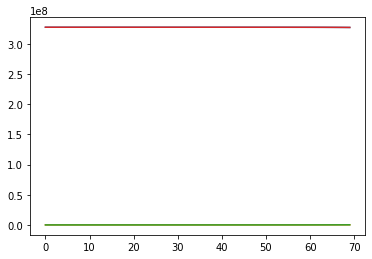

In [63]:
plt.plot(np.arange(len(I)),S)
plt.plot(np.arange(len(I)),I)
plt.plot(np.arange(len(I)),R)
plt.plot(np.arange(len(I)),D)

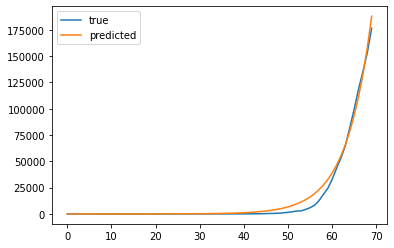

In [64]:
plt.plot(np.arange(len(Ic)),Ic,label = 'true')
plt.plot(np.arange(len(I)),I , label = 'predicted')
plt.legend()

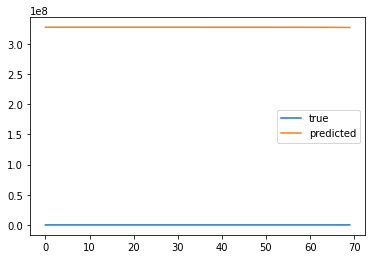

In [65]:
plt.plot(np.arange(len(Dc)),Dc,label='true')
plt.plot(np.arange(len(D)),D,label = 'predicted')
plt.legend()

In [24]:
D[-1]

325924631.52233434

In [25]:
print(np.max(np.abs((Ic-I))))

137875.12434782286


In [26]:
print(np.max(np.abs((Dc-D))))

327199999.0


In [27]:
Ic[-1]

445791.0

In [28]:
def interpolate(y,d):
    #d  = 10
    h =  1/d
    n = len(y)

    y_interp = []
    y_interp.append(y[0])

    for i in range(n-1):
        for t in range(d):
            t = t+1
            y_interp.append(y[i] + t*h*(y[i+1]-y[i]))
    y_interp = np.array(y_interp)
    return y_interp

In [32]:
def solve_sird_euler(beta,gamma,mu,d):
    S_t = []
    I_t = []
    R_t = []
    D_t = []

    S_t.append(us_population-1.)
    I_t.append(1.)
    R_t.append(0.)
    D_t.append(0.)
    
    h = 1/d
    
    beta_t = interpolate(beta,d)
    gamma_t = interpolate(gamma,d)
    mu_t = interpolate(mu,d)
    
    for t in range((num_times-1)*d):
        Snew = S_t[t] - h*(beta_t[t]/us_population * S_t[t]*I_t[t])
        Inew = I_t[t] + h*(beta_t[t]/us_population * S_t[t]*I_t[t] - gamma_t[t]*I_t[t] - mu_t[t]*I_t[t])
        Rnew = R_t[t] + h*(gamma_t[t]* I_t[t])
        Dnew = D_t[t] + h*(mu_t[t]*I_t[t])
        S_t.append(Snew)
        I_t.append(Inew)
        R_t.append(Rnew)
        D_t.append(Dnew)
    
    S = []
    I = []
    R = []
    D = []
    
    for i in range(num_times):
        S.append(S_t[10*i])
        I.append(I_t[10*i])
        R.append(R_t[10*i])
        D.append(D_t[10*i])
    
    return [S,I,R,D]

In [106]:
from scipy.optimize import minimize

def constraint1(x):
    return x[0]+x[1]+x[2]

def minf(x):
    beta = x[0]
    gamma = x[1]
    mu = x[2]
    
    beta = [beta for i in range(num_times)]
    gamma = [gamma for i in range(num_times)]
    mu = [mu for i in range(num_times)]
    
    #d = 10
    
    S = []
    I = []
    R = []
    D = []

    S.append(us_population-1.)
    I.append(1.)
    R.append(0.)
    D.append(0.)

    for i in range(num_times-1):
        Snew = S[i] - beta[i]/us_population * S[i]*I[i]
        Inew = I[i] + beta[i]/us_population * S[i]*I[i] - gamma[i]*I[i] - mu[i]*I[i]
        Rnew = R[i] + gamma[i]* I[i]
        Dnew = D[i] + mu[i]*I[i]
        S.append(Snew)
        I.append(Inew)
        R.append(Rnew)
        D.append(Dnew)

    I = np.array(I)
    D = np.array(D)
    R = np.array(R)
    D = np.array(S)

    
    epsilon = 0.000001
    Ed1 = np.sum((np.log(Ic+epsilon)-np.log(I+epsilon))**2 + (np.log(Dc+epsilon)-np.log(D+epsilon))**2)
    Ed2 = 0.01*(np.log(np.max(Ic)+epsilon)/np.max(Ic)) * np.sum((Ic-I)**2+ (Dc-D)**2)
    #sumr = 0
    #for it in range(num_times-1):
    #    sumr = sumr + (beta[it]-beta[it+1])**2 + (gamma[it]-gamma[it+1])**2 + 100*(mu[it]-mu[it+1])**2
    #Er = 100*np.log(np.max(Ic)+epsilon)/0.7215546733084348*sumr
   # 
    #E0 = 100*np.log(np.max(Ic)+epsilon)/0.7215546733084348*((beta[0]-0.7215546733084348)**2+(gamma[0]- 0.5260372903228209)**2 +100*(mu[0]-0.003972672766524191)**2)

    #return np.sum((Ic-I)**2) + 10*np.sum((Dc-D)**2)
    return Ed1 + Ed2

bnds = [(0, 1), (0, 1),(0,1)]
res = minimize(minf,[0.4,0.3,0.03],bounds=bnds)
[beta1,gamma1,mu1] = res.x

In [107]:
np.log(np.exp(1))

1.0

In [108]:
print(res.x[0])
print(res.x[1])
print(res.x[2])

1.0
0.10417062477274751
0.04019663231877303


In [165]:
end_time = 30
num_times = len(df_infected['US'].values[0:end_time])
print(num_times)

Ic = df_infected['US'].values[0:end_time]
Dc = df_deaths['US'].values[0:end_time]

Ic = to_float_vec(Ic)
Dc = to_float_vec(Dc)

30


In [169]:
from scipy.optimize import minimize

def minf(x):
    beta = x[0:end_time]
    gamma = x[end_time:2*end_time]
    mu = x[2*end_time:3*end_time]
    
    S = []
    I = []
    R = []
    D = []

    S.append(us_population-1.)
    I.append(1.)
    R.append(0.)
    D.append(0.)

    for i in range(num_times-1):
        Snew = S[i] - beta[i]/us_population * S[i]*I[i]
        Inew = I[i] + beta[i]/us_population * S[i]*I[i] - gamma[i]*I[i] - mu[i]*I[i]
        Rnew = R[i] + gamma[i]* I[i]
        Dnew = D[i] + mu[i]*I[i]
        S.append(Snew)
        I.append(Inew)
        R.append(Rnew)
        D.append(Dnew)
        
    I = np.array(I)
    D = np.array(D)
    
    epsilon = 0.0001
    Ed1 = np.sum((np.log(Ic+epsilon)-np.log(I+epsilon))**2 + (np.log(Dc+epsilon)-np.log(D+epsilon))**2)
    Ed2 = 0.01*(np.log(np.max(Ic)+epsilon)/np.max(Ic)) * np.sum((Ic-I)**2+ (Dc-D)**2)
    sumr = 0
    for it in range(num_times-1):
        sumr = sumr + (beta[it]-beta[it+1])**2 + (gamma[it]-gamma[it+1])**2 + 100*(mu[it]-mu[it+1])**2
    Er = 100*np.log(np.max(Ic)+epsilon)/0.7215546733084348*sumr
    
    E0 = 100*np.log(np.max(Ic)+epsilon)/0.7215546733084348*((beta[0]-0.7215546733084348)**2+(gamma[0]- 0.5260372903228209)**2 +100*(mu[0]-0.003972672766524191)**2)

    #return np.sum((Ic-I)**2) + 100*np.sum((Dc-D)**2)
    #print(Ed1+Ed2+Er+E0)
    return Ed1 + Ed2 + Er + E0

bnds = [(0, 1) for i in range(end_time*3)]
beta_0 = np.array([0.7215546733084348 for i in range(end_time)])
gamma_0 = np.array([0.5260372903228209 for i in range(end_time)])
mu_0 = np.array([0.003972672766524191 for i in range(end_time)])
res = minimize(minf,[beta_0,gamma_0,mu_0],bounds=bnds,options={'disp': True},method = 'L-BFGS-B')

In [170]:
print(res)

      fun: 4.069880332446453
 hess_inv: <90x90 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.64128164e+00,  1.36565179e+01, -1.81922557e+00, -3.42153958e+00,
       -2.22588978e+00,  1.86119387e-01,  5.44143663e-01,  1.06635643e+00,
        1.42446943e+00,  2.19293463e+00,  2.15365556e+00,  3.09734007e+00,
        1.90641796e+00,  2.79879648e+00,  2.63025708e+00,  2.34130209e+00,
        3.06965129e+00,  1.75714936e+00,  2.60391113e+00,  2.21916601e+00,
        1.45507251e+00,  1.97074250e+00,  1.08649481e+00,  5.02263742e-01,
       -5.00741510e+00, -1.34673313e+00,  1.14406522e+01,  4.23773363e+00,
       -1.08006519e+00,  1.57271609e+00, -1.27962761e+01, -4.96364070e+00,
       -8.64929799e+00,  5.07360314e+00,  1.41108742e+00, -2.33083242e-01,
       -5.80432147e-01, -1.50461013e+00, -1.97259240e+00, -1.76869008e+00,
       -1.56220219e+00, -3.09096944e+00, -1.90640463e+00, -2.79879844e+00,
       -2.62772746e+00, -2.10587734e+00, -2.56145789e+00, -2.59830468e+00,
  

In [168]:
beta1 = res.x[0:end_time]
gamma1 = res.x[end_time:2*end_time]
mu1 =res.x[2*end_time:3*end_time]

In [113]:
beta1 = [beta1 for i in range(num_times)]
gamma1 = [gamma1 for i in range(num_times)]
mu1 = [mu1 for i in range(num_times)]

In [154]:
print(beta1[0])

0.74845723761342


In [155]:
#[S,I,R,D] = solve_sird_euler(beta1,gamma1,mu1,10)

In [171]:
S = []
I = []
R = []
D = []

S.append(us_population-1.)
I.append(1.)
R.append(0.)
D.append(0.)

for i in range(num_times-1):
    Snew = S[i] - beta1[i]/us_population * S[i]*I[i]
    Inew = I[i] + beta1[i]/us_population * S[i]*I[i] - gamma1[i]*I[i] - mu1[i]*I[i]
    Rnew = R[i] + gamma1[i]* I[i]
    Dnew = D[i] + mu1[i]*I[i]
    S.append(Snew)
    I.append(Inew)
    R.append(Rnew)
    D.append(Dnew)

I = np.array(I)
D = np.array(D)
R = np.array(R)
S = np.array(S)

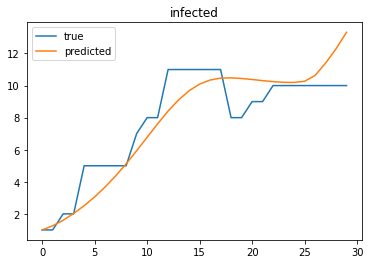

In [172]:
plt.plot(np.arange(len(Ic)),Ic,label = 'true')
plt.plot(np.arange(len(I)),I , label = 'predicted')
plt.legend()
plt.title('infected')
plt.savefig('n_infected_232')

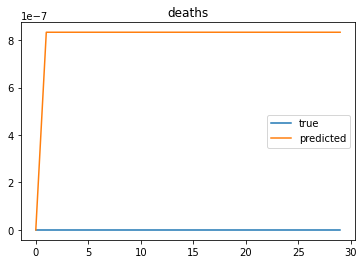

In [173]:
plt.plot(np.arange(len(Dc)),Dc,label='true')
plt.plot(np.arange(len(D)),D,label = 'predicted')
plt.title('deaths')
plt.legend()
plt.savefig('n_deaths_232')

In [127]:
print(beta1[0])
print(gamma1[0])
print(mu1[0])

0.7215546733084348
0.5260372903228209
0.003972672766524191
